In [1]:
import numpy as np
import cvxpy as cp
from matplotlib import pyplot as plt

from scipy.linalg import fractional_matrix_power
from sklearn.linear_model import OrthogonalMatchingPursuit
from tqdm import tqdm
from itertools import combinations

import warnings
warnings.filterwarnings("ignore")

The full pipeline to learn the sheaf laplacian is going to take into account several steps. 
+ First of all, we take as granted the imputation of the maps via KKT on a given set of edges: we initialize the algorithm to work on the full graph starting from all maps being identity maps. 
+ We leverage structured dictionaries based on sheaf convolutional filters to learn the best representation of the 0-cochains with a double localization quality within each subdictionary: each atom gives first of all a node domain localization, and then a rank-1 stalk subspace localization. 
+ We then define a greedy criterion to start removing edges: at each iteration we compute all the possible representation of the 0-cochains removing one of the possible edges, and we decide to remove the edge yielding the best improvement on the sparse coding in terms of reconstruction error.
+ Finally, once an edge has been removed, we compute all the restriction maps again and repeat the procedure until a convergence criterion is met. 

In [3]:
N = 10
edges = []

cutoff = 0.5
theta = 0.9

points = np.random.rand(N, 2)

A = np.zeros((N,N))
W = np.zeros((N,N))

for i in range(N):
    for j in range(i+1, N):
        
        A[i,j] = np.linalg.norm(points[i,:] - points[j,:]) <= cutoff
        A[j,i] = np.linalg.norm(points[i,:] - points[j,:]) <= cutoff

        if A[i,j] == 1:
            edges.append((i,j))

In [4]:
def random_sheaf(
        V:int,
        d:int,
        edges:list
        ) -> np.array:

    E = len(edges)

    # Incidency linear maps

    F = {
        e:{
            e[0]:np.random.randn(d,d),
            e[1]:np.random.randn(d,d)
            } 
            for e in edges
        }                                           

    # Coboundary maps

    B = np.zeros((d*E, d*V))                        

    for i in range(len(edges)):

        # Main loop to populate the coboundary map

        edge = edges[i]

        u = edge[0] 
        v = edge[1] 

        B_u = F[edge][u]
        B_v = F[edge][v]

        B[i*d:(i+1)*d, u*d:(u+1)*d] = B_u           
        B[i*d:(i+1)*d, v*d:(v+1)*d] = - B_v

    L_f = B.T @ B

    return L_f

In [5]:
d = 10
Lf = random_sheaf(N, d, edges)

In [6]:
D = np.diag(np.diagonal(Lf))

In [7]:
Lf = fractional_matrix_power(D, -0.5) @ Lf @ fractional_matrix_power(D, -0.5)

In [8]:
band1 = np.array([i in range(0,25) for i in range(100)])
band2 = np.array([i in range(25,50) for i in range(100)]) 
band3 = np.array([i in range(50,75) for i in range(100)])
band4 = np.array([i in range(75,100) for i in range(100)])

bands = [band1, band2, band3, band4]

In [9]:
Lambda, U = np.linalg.eig(Lf)
Lambda = np.sort(Lambda)

In [10]:
J = 400
DD = np.zeros((N*d, J))

In [11]:
for j in range(J): 

    B = j // 100
    h = np.copy(Lambda)
    h[~bands[B]] = 0
    h *= np.random.rand(h.shape[0],1)[:,0]
    n = np.random.choice(d*N)

    DD[:,j] = (U @ np.diag(h) @ U.T)[:,n]

In [12]:
M = 1000 
Y_train = np.zeros((N*d,M))

for m in range(M):
    T = np.random.choice(J, 4)
    Y_train[:,m] = DD[:,T] @ np.random.rand(4)

test_size = 2000
Y_test = np.zeros((N*d,test_size))

for t in range(test_size):
    T = np.random.choice(J, 4)
    Y_test[:,t] = DD[:,T] @ np.random.rand(4)

In [13]:
Y_train.shape

(100, 1000)

In [14]:
c = 1
eps = 0.01

T0 = 20         # Assumed sparsity
S = 4           # Number of dictionaries
K = 5           # Power of the laplacian

In [15]:
def vecOMP(Y, D, T0):
    
    batch_size, _ = Y.shape
    dictionary_dim = D.shape[1]

    # Initialize the coefficient matrix
    X = np.zeros((batch_size, dictionary_dim))

    # Initialize the OMP model
    omp = OrthogonalMatchingPursuit(n_nonzero_coefs=T0)

    # Loop through each sample in the batch
    for i in range(batch_size):
        # Fit the model to each sample
        omp.fit(D, Y[i])

        # Get the estimated coefficients for the current sample
        X[i, :] = omp.coef_
    
    return X

In [15]:
'''
def vecOMP(Y, D, T0):
    batch_size, _ = Y.shape
    dictionary_dim = D.shape[1]
    
    S = np.zeros((T0, batch_size), dtype=int)
    X = np.zeros((batch_size, dictionary_dim))
    R = np.copy(Y)
    
    for k in range(T0):

        corr = np.abs(R @ D)

        # Masking the previously selected atoms
        mask_1 = np.zeros_like(corr, dtype=bool)
        mask_1[np.arange(batch_size)[:, None], S[:k,:].transpose(1,0)] = True
        corr[mask_1] = -np.inf

        # Selected highest correlated atoms
        selected = np.argmax(corr, axis=1)
        S[k, :] = selected

        # Solve least square problem
        dics = np.linalg.pinv(D[:, S[:k+1,:]].transpose(2,0,1))
        X_hat = np.matmul(dics, Y  [:,:,None])[:,:,0]

        # Update the estimate
        mask_2 = np.zeros_like(X, dtype=bool)
        mask_2[np.arange(batch_size)[:, None], S[:k+1,:].transpose(1,0)] = True
        X[mask_2] = X_hat.reshape(-1)

        # Update the residuals
        R = Y - (X @ D.T)
    
    return X
'''

'\ndef vecOMP(Y, D, T0):\n    batch_size, _ = Y.shape\n    dictionary_dim = D.shape[1]\n    \n    S = np.zeros((T0, batch_size), dtype=int)\n    X = np.zeros((batch_size, dictionary_dim))\n    R = np.copy(Y)\n    \n    for k in range(T0):\n\n        corr = np.abs(R @ D)\n\n        # Masking the previously selected atoms\n        mask_1 = np.zeros_like(corr, dtype=bool)\n        mask_1[np.arange(batch_size)[:, None], S[:k,:].transpose(1,0)] = True\n        corr[mask_1] = -np.inf\n\n        # Selected highest correlated atoms\n        selected = np.argmax(corr, axis=1)\n        S[k, :] = selected\n\n        # Solve least square problem\n        dics = np.linalg.pinv(D[:, S[:k+1,:]].transpose(2,0,1))\n        X_hat = np.matmul(dics, Y  [:,:,None])[:,:,0]\n\n        # Update the estimate\n        mask_2 = np.zeros_like(X, dtype=bool)\n        mask_2[np.arange(batch_size)[:, None], S[:k+1,:].transpose(1,0)] = True\n        X[mask_2] = X_hat.reshape(-1)\n\n        # Update the residuals\n   

In [16]:
# Dictionary update subroutine

def LaplacianPowers(L, K):
    powers = np.zeros((K+1, L.shape[0], L.shape[1]))
    for k in range(K+1):
        powers[k,:,:] = np.linalg.matrix_power(L, k)

    return powers 

def DicUp(LaplPowers, K, S, Y, X, d, N, c, eps, mu = 1):
    # Variables
    alpha = cp.Variable((K+1, S))

    # Define D_s expressions
    D_s_list = []
    for s in range(S):
        D_s = sum(alpha[k, s] * LaplPowers[k,:,:] for k in range(K+1))
        D_s_list.append(D_s)

    # Objective function
    D = cp.hstack(D_s_list)
    objective = cp.Minimize(cp.norm(Y - D @ X, 'fro')**2 + mu * cp.norm(alpha, 2)**2)

    # Constraints
    constraints = []
    for s in range(S):
        constraints.append(D_s_list[s] >> 0)
        constraints.append(D_s_list[s] << c * np.eye(d*N))

    sum_D_s = sum(D_s_list)
    constraints.append(sum_D_s >> (c - eps) * np.eye(d*N))
    constraints.append(sum_D_s << (c + eps) * np.eye(d*N))

    # Problem definition and solving
    prob = cp.Problem(objective, constraints)
    prob.solve(solver=cp.MOSEK,
               mosek_params = { 'MSK_IPAR_INTPNT_SOLVE_FORM':   'MSK_SOLVE_PRIMAL' })

    alpha_star = alpha.value
    D_s_list = []
    for s in range(S):
        D_s = sum(alpha_star[k, s] * LaplPowers[k,:,:] for k in range(K+1))
        D_s_list.append(D_s)

    # Objective function
    D = np.hstack(D_s_list)
    return D, alpha_star

In [17]:
# Parametric dictionary learning algorithm 

def ParametricDictionaryLearning(Lf, Y, T0, K, S, d, N, c, eps, mu = 1, MAX_ITER = 5):

    loss = []

    # Precompute Laplacian powers
    LP = LaplacianPowers(Lf, K)

    # Dictionary initialization 
    D_s_list = []
    for _ in range(S):
        D_s = sum(LP[k,:,:] for k in range(K+1))
        D_s_list.append(D_s)

    D = np.hstack(D_s_list)

    # Alternated learning procedure
    for _ in tqdm(range(MAX_ITER)):
        
        # Sparse coding update
        X = vecOMP(Y.T, D, T0).T

        # Dictionary update
        D, alpha_star = DicUp(LP, K, S, Y, X, d, N, c, eps, mu)
        D = np.apply_along_axis(lambda x: x / np.linalg.norm(x), axis = 0, arr = D)

        loss.append(np.linalg.norm(Y - D @ X, ord = 'fro'))
        
    return D, X, alpha_star, loss

In [18]:
def GreedySelection(alpha, edges, d, Lf, maps, K, Y, D, X):
    
    impros = {edge:None for edge in edges}

    for edge in edges:

        # Mask the sheaf laplacian assuming that such an edge is removed
        L = np.copy(Lf)
        u = edge[0]
        v = edge[1]

        L[u*d:(u+1)*d,v*d:(v+1)*d] = 0
        L[v*d:(v+1)*d,u*d:(u+1)*d] = 0

        L[u*d:(u+1)*d,u*d:(u+1)*d] -= maps[edge][u].T @ maps[edge][u]
        L[v*d:(v+1)*d,v*d:(v+1)*d] -= maps[edge][v].T @ maps[edge][v]

        LaplPowers = LaplacianPowers(L, K)

        # Compute the retrieved dictionary 
        D_s_list = []
        for s in range(S):
            D_s = sum(alpha[k, s] * LaplPowers[k,:,:] for k in range(K+1))
            D_s_list.append(D_s)

        D_ = np.hstack(D_s_list)

        # Store the improvement
        impros[edge] = np.linalg.norm(Y - D @ X) - np.linalg.norm(Y - D_ @ X)

    return [edge for edge in edges if edge != max(impros, key = impros.get)]

In [19]:
def KKTLaplacianUpdate(D, X, d, edges, N, Q, Y = None):
       
    def premultiplier(Xu, Xv):
        uu = np.linalg.inv(Xu @ Xu.T)
        uv = Xu @ Xv.T
        vv = np.linalg.inv(Xv @ Xv.T)
        vu = Xv @ Xu.T

        return (uu, uv, vv, vu)

    def chi_u(uu, uv, vv, vu):

        return (uu @ uv + np.eye(uu.shape[0])) @ vv @ (vu @ uu @ uv @ vv - np.eye(uu.shape[0])) @ vu @ uu - uu

    def chi_v(uu, uv, vv, vu):

        return (uu @ uv + np.eye(uu.shape[0])) @ vv @ (vu @ uu @ uv @ vv - np.eye(uu.shape[0]))

    T = 0
    if Y is None:
        Y = D @ X
        
    maps_ = {
        edge : {
            edge[0] : np.zeros((d,d)),
            edge[1] : np.zeros((d,d))
        }
    for edge in edges
    }

    for e in edges:
        
        u = e[0]
        v = e[1]

        X_u = Y[u*d:(u+1)*d,:]
        X_v = Y[v*d:(v+1)*d,:]
        
        uu, uv, vv, vu = premultiplier(X_u, X_v)

        maps_[e][u] = chi_u(uu, uv, vv, vu)
        maps_[e][v] = chi_v(uu, uv, vv, vu)
        
        T += np.trace(maps_[e][u]) + np.trace(maps_[e][v])

    maps_ = {
        edge : {
            edge[0] : Q/T * maps_[edge][edge[0]],
            edge[1] : Q/T * maps_[edge][edge[1]]
        }
    for edge in edges
    }

    E = len(edges)
    B_hat = np.zeros((d*E, d*N))

    for i, edge in enumerate(edges):

        u = edge[0] 
        v = edge[1] 

        B_u = maps_[edge][u]
        B_v = maps_[edge][v]

        B_hat[i*d:(i+1)*d, u*d:(u+1)*d] = B_u
        B_hat[i*d:(i+1)*d, v*d:(v+1)*d] = - B_v

    # Sheaf Laplacian

    L_f = B_hat.T @ B_hat

    return L_f, maps_

In [20]:
def MapsSolver(Y, d, edges, N):

    obj = 0
    trace = 0

    Fs = {
        edge: {
            edge[0]:None,
            edge[1]:None
        }
        for edge in edges
    }

    # Loop over edges to define variables and construct objective
    for edge in edges:
        u = edge[0]
        v = edge[1]

        Y_u = Y[u*d:(u+1)*d, :]
        Y_v = Y[v*d:(v+1)*d, :]

        # Define optimization variables for each edge
        Fs[edge][u] = cp.Variable((d, d))
        Fs[edge][v] = cp.Variable((d, d))

        # Update objective and trace
        obj += cp.norm(Fs[edge][u] @ Y_u - Fs[edge][v] @ Y_v, 'fro')**2
        trace += cp.trace(Fs[edge][u]) + cp.trace(Fs[edge][v])

    # Define the trace constraint
    trace_constraint = (trace == N)

    # Define the problem
    problem = cp.Problem(cp.Minimize(obj), [trace_constraint])

    # Solve the problem
    problem.solve(solver=cp.MOSEK,
                  mosek_params = { 'MSK_IPAR_INTPNT_SOLVE_FORM':   'MSK_SOLVE_PRIMAL' })

    # Return the solution
    return Fs

def ImplicitLaplacianUpdate(D, X, d, edges, N, Q, Y = None):    
    T = 0
    if Y is None:
        Y = D @ X

    maps_ = MapsSolver(Y, d, edges, Q)

    for edge in edges:
        T += np.trace(maps_[edge][edge[0]].value) + np.trace(maps_[edge][edge[1]].value)

    maps = {
        edge: {
            edge[0] : Q/T * maps_[edge][edge[0]].value,
            edge[1] : Q/T * maps_[edge][edge[1]].value
        }
        for edge in edges
    }

    Lf = np.zeros((d*N, d*N))
    for edge in edges:

        u = edge[0] 
        v = edge[1] 

        Lf[u*d:(u+1)*d,u*d:(u+1)*d] += maps[edge][u].T @ maps[edge][u]
        Lf[v*d:(v+1)*d,v*d:(v+1)*d] += maps[edge][v].T @ maps[edge][v]
        Lf[u*d:(u+1)*d,v*d:(v+1)*d] = - maps[edge][u].T @ maps[edge][v]
        Lf[v*d:(v+1)*d,u*d:(u+1)*d] = - maps[edge][v].T @ maps[edge][u]

    return Lf, maps


In [21]:
def LaplacianLearningPipeline(
        Y, 
        E0,
        T0, 
        K, 
        S, 
        d, 
        N, 
        c, 
        eps, 
        Q = 1,
        mu = 1, 
        MAX_ITER = 10,
        KKT = False):
    
    # Initialization - Full graph with Gaussian random maps

    edges = list(combinations(range(N),2))

    '''
    maps = {
    edge: {
        edge[0]:None,
        edge[1]:None
    } for edge in edges
    }

    B = np.zeros((d*len(edges), d*N))                        

    for i in range(len(edges)):

        # Main loop to populate the coboundary map
        edge = edges[i]

        u = edge[0] 
        v = edge[1] 

        B_u = np.random.randn(d,d)
        B_v = np.random.randn(d,d)

        maps[edge][u] = B_u
        maps[edge][v] = B_v

        B[i*d:(i+1)*d, u*d:(u+1)*d] = B_u           
        B[i*d:(i+1)*d, v*d:(v+1)*d] = - B_v
    Lf = B.T @ B
    '''

    if KKT:
        Lf, maps = KKTLaplacianUpdate(None, None, d, edges, N, Q, Y)
    else:
        Lf, maps = ImplicitLaplacianUpdate(None, None, d, edges, N, Q, Y)

    Lf = fractional_matrix_power(np.diag(np.diagonal(Lf)), -0.5) @ Lf @ fractional_matrix_power(np.diag(np.diagonal(Lf)), -0.5)

    # Main loop - First try with a priori knowledge of the number of connections
    loss = []

    while len(edges) > E0:
        
        # Dictionary learning phase
        D, X, alpha, loss_ = ParametricDictionaryLearning(Lf, Y, T0, K, S, d, N, c, eps, mu, MAX_ITER)
        loss += loss_

        # Greedy deleting one edge from the graph
        edges = GreedySelection(alpha, edges, d, Lf, maps, K, Y, D, X)

        # Rebuilding the sheaf laplacian on the new graph
        if KKT:
            Lf, maps = KKTLaplacianUpdate(D, X, d, edges, N, Q)
        else:
            Lf, maps = ImplicitLaplacianUpdate(D, X, d, edges, N, Q)

        Lf = fractional_matrix_power(np.diag(np.diagonal(Lf)), -0.5) @ Lf @ fractional_matrix_power(np.diag(np.diagonal(Lf)), -0.5)
        
    return Lf, edges, loss, maps, D, X 

In [22]:
E0 = len(edges)
print(E0)

19


In [23]:
L_hat, edges_, loss, maps, D, X = LaplacianLearningPipeline(Y_train, E0, T0, K, S, d, N, c, eps, MAX_ITER=5)

100%|██████████| 5/5 [00:46<00:00,  9.26s/it]


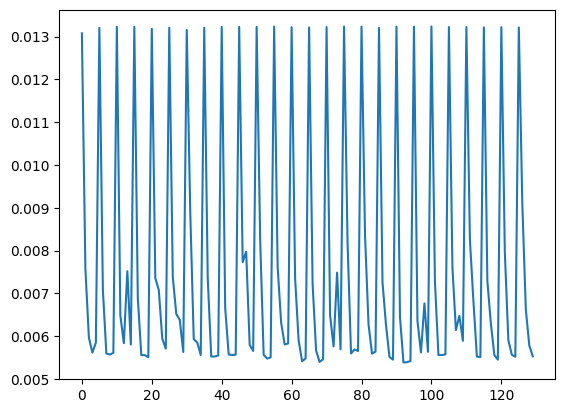

In [24]:
plt.plot([L / Y_train.shape[1] for L in loss])

In [25]:
L_hat

array([[ 1.        , -0.61424513, -0.71923502, ..., -0.09899134,
        -0.05731279,  0.00780764],
       [-0.61424513,  1.        ,  0.64785059, ...,  0.02216975,
        -0.03352373, -0.05850861],
       [-0.71923502,  0.64785059,  1.        , ...,  0.00768402,
        -0.00660584, -0.06945727],
       ...,
       [-0.09899134,  0.02216975,  0.00768402, ...,  1.        ,
        -0.06111332, -0.3512898 ],
       [-0.05731279, -0.03352373, -0.00660584, ..., -0.06111332,
         1.        ,  0.46907552],
       [ 0.00780764, -0.05850861, -0.06945727, ..., -0.3512898 ,
         0.46907552,  1.        ]])

In [26]:
EDG = set(edges)
EDG_HAT = set(edges_)

In [27]:
len(EDG.intersection(EDG_HAT))/E0

0.8947368421052632

In [28]:
np.trace(Y_train.T @ Lf @ Y_train)

106.87401459455732

In [29]:
np.trace(Y_train.T @ L_hat @ Y_train)

45.207519273983074

Best result so far!